## Electronics Product Reviews on Amazon


Previously, we trained our classifier on a perfectly balanced set of data. That left us with two drawbacks:
1. Smaller amount of data (We had to toss a "helpful" reviews in order to maintain that 50-50 balance
2. The distribution of the data did not really represent the actual distrubution of the data

In this version of experiments, we're going to train the classifier on the unbalanced data. Furthermore, to make things a little easier, we'll be using the "from_df method for the dataloaders (LM & Classifier) to avoid having to populate folders with individual text files. 

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML
from fastai.text.all import *

In [3]:
import pandas as pd
import time

## Prepping the Data
A little bit of prepping was already done in our Electronics_Data_Prep workbook. Let us import the csv file that contains all the data with 50+ helpfulness ratings and no duplicate text in the reviewText column. We will use this data both for training our LM as well as our Classifier. 

In [4]:
path = Path("electronics_all_classifier_data_unbalanced_uniq.csv")

In [5]:
df = pd.read_csv(path)

In [6]:
df.head()

,helpful,reviewText,overall,summary,num_helpful_votes,num_total_votes,helpful_ratio,is_helpful
0,"[70, 92]","I purchased this mount for my 37 inch LCD TV. Installation was easy... The trouble I encountered was due to a bad wall stud finder. Make sure you have one when you install this mount because you need to screw the mount into a wall stud or at least have one screw into a wall stud.The arm of the mount sags after I hooked up my 37in. LCD TV to the mount. My TV is within the weight limit of this mount (less than 55lbs.) but the arm still sags due to the weight of the TV. I guess as long as it supports my TV, the sagging shouldn't be an issue. It just looks funny from the side. I do retr...",3.0,It Works But Could Be Better,70,92,0.760870,1.0
1,"[52, 57]","Update 2-Sep-13:Put on CM 10.2.2 (Android 4.2.2) last week. I've got to say, it's nice. Fonts are small, though one could choose dpi if they had visual issues (google this). Netflix works, and the UI is really quite nice - pretty much no need for Button Savior, battery life is same as CM7. In general I like it better than CM7. My major hardware dislikes are headphone jack requires a little wiggling sometimes, no BT, no GPS. Seems to charge fine with a normal cable.At this point I lean toward Samsung tablets - I like the IR and the microSD slot.===========================Update Jul 20...",1.0,Very Limited Unless You Modify It,52,57,0.912281,1.0
2,"[69, 72]","I've owned an Ipad 2, an original Kindle Fire, and first generation 3g dual screen Nook. I decided it was time to upgrade my original Nook and went with this tablet. I purchased mine direct from B&N. This is a fantastic ereader with a few tablet functions. I really like the interface on this ereader more so than the Kindle Fire. Don't get me wrong, the Kindle Fire is a very nice device, but I like the personal touch I can give the Nook HD. It's more customizable.I can create my own wallpaper and customize my home screen. The ereader is very light and easy to hold with a contoured, grippy b...",5.0,Great little device!,69,72,0.958333,1.0
3,"[48, 54]","I tried Kindle hd, Samsung tab 2, and Nexus 7. I returned them all since I had high standard for display quality of tablets. I was very disappointed by their color faithfulness and/or resolution.One day I saw a hot discussion online about discounted nook hd from Staples. I rushed to a local store and played nook hd. Its screen immediately attracted me: bright, white, colorful, high resolution. This is what I want!I have being enjoying nook hd ever since. It has THE BEST SCREEN period!Online community like XDA forum has ways to root nook hd and install Android by yourself. I rooted mine an...",4.0,"best screen out of all 7"" tablets",48,54,0.888889,1.0
4,"[226, 231]","The Nook tablet is a great color e-reader with the ""bonus"" of being able to read your email, shop on Amazon.com, surf the web, watch tv shows on Hulu Plus, movies on Netflix, and listen to the world's largest selection of music on Pandora Radio. I added a 16gb sd card filled with thousands of my favorite songs. But, the Nook is designed to be an ereader...it is not a games tablet, or an IPad.I got my Nook Tablet (8gb version) from Barnes & Noble because of the extra discount I got with my B&N; membership...the price was MUCH less than advertised by most internet venders. I already have a ...",5.0,Great Color E-Reader With Extra Features,226,231,0.978355,1.0


Neither the LM nor the Classifier needs most of these columns. Let us remove them.

In [7]:
df.drop(columns=["helpful", "overall", "summary", "num_helpful_votes", "num_total_votes","helpful_ratio"], inplace=True)

In [8]:
df.head(2)

,reviewText,is_helpful
0,"I purchased this mount for my 37 inch LCD TV. Installation was easy... The trouble I encountered was due to a bad wall stud finder. Make sure you have one when you install this mount because you need to screw the mount into a wall stud or at least have one screw into a wall stud.The arm of the mount sags after I hooked up my 37in. LCD TV to the mount. My TV is within the weight limit of this mount (less than 55lbs.) but the arm still sags due to the weight of the TV. I guess as long as it supports my TV, the sagging shouldn't be an issue. It just looks funny from the side. I do retr...",1.0
1,"Update 2-Sep-13:Put on CM 10.2.2 (Android 4.2.2) last week. I've got to say, it's nice. Fonts are small, though one could choose dpi if they had visual issues (google this). Netflix works, and the UI is really quite nice - pretty much no need for Button Savior, battery life is same as CM7. In general I like it better than CM7. My major hardware dislikes are headphone jack requires a little wiggling sometimes, no BT, no GPS. Seems to charge fine with a normal cable.At this point I lean toward Samsung tablets - I like the IR and the microSD slot.===========================Update Jul 20...",1.0


In [9]:
df['is_helpful'].value_counts()

1.0    16975
0.0     2010
Name: is_helpful, dtype: int64

In [10]:
df.shape

(19009, 2)

Since the shape method showed us that we have 19009 rows, but the above 1.0/0.0 values only add up to 18985, it seems that 24 values are neither 1.0 nor 0.0. Let us check whether they might contain the value NaN.

In [11]:
df['is_helpful'].isna().value_counts()

False    18985
True        24
Name: is_helpful, dtype: int64

Turns out these 24 cells contain, indeed, Nans. We're about to use a function rom sklearn that hates Nans, so we must ensure that there are non Nans in the "is_helpful" column.

In [12]:
df = df[df.is_helpful.isna() == False]

In [13]:
df.shape

(18985, 2)

In [14]:
df['is_helpful'].isna().value_counts()

False    18985
Name: is_helpful, dtype: int64

The new dataframe does not contain Nans in the "is_helpful" column anymore. However, the dtype int64 will be too large for our future uses. Let's convert it. 

In [15]:
df = df.astype({'is_helpful':'float32'})

In [16]:
df.is_helpful.dtype

dtype('float32')

Having cleaned up the dataframe, let us know separate out a bit of test data for the end. Since our data is unbalanced this time around, we need to make sure that whatever we separate out is just as unbalanced. We do this using the parameter "stratify"

In [17]:
from sklearn.model_selection import train_test_split

# Since the data is unbalanced, stratify the train-test splits on "is_helpful"
train_unbal_df, test_unbal_df = train_test_split(
    df, test_size=0.20, stratify=df["is_helpful"], random_state=42
)


In [18]:
train_unbal_df.shape, test_unbal_df.shape

((15188, 2), (3797, 2))

### Training the LM

In [19]:
start = time.time()

dls_lm = TextDataLoaders.from_df(
    train_unbal_df, 
    seed=42, 
    seq_len=72,
    valid_pct = 0.10,
    text_col="reviewText", 
    label_col="is_helpful", 
    bs = 64, 
    is_lm = True
)

end = time.time()
elapsed = end - start
print("TextDataLoader took this long: ", elapsed)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


TextDataLoader took this long:  39.0287299156189


In [20]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos i purchased this "" bulk packaging "" 32 gb micro xxup xxunk card from xxmaj marketplace seller , komputerbay . i was wary of purchasing this particular product from a marketplace seller because of the rampant availability of fake / counterfeit micro xxup sdhc card being sold on ebay and other sales channels , but since this was being offered via xxmaj amazon fulfillment , i thought it would be a","i purchased this "" bulk packaging "" 32 gb micro xxup xxunk card from xxmaj marketplace seller , komputerbay . i was wary of purchasing this particular product from a marketplace seller because of the rampant availability of fake / counterfeit micro xxup sdhc card being sold on ebay and other sales channels , but since this was being offered via xxmaj amazon fulfillment , i thought it would be a low"
1,xxup not have to use noise reduction post processing for printed images in large xxunk with my last entry i will simply say that i am pleased to have made an investment in the new xxmaj mark xxup iv . xxmaj it surpasses my xxmaj mark xxrep 3 i in a way that will now allow me to press the limits of my ability to capture even more compelling imagery . xxmaj,not have to use noise reduction post processing for printed images in large xxunk with my last entry i will simply say that i am pleased to have made an investment in the new xxmaj mark xxup iv . xxmaj it surpasses my xxmaj mark xxrep 3 i in a way that will now allow me to press the limits of my ability to capture even more compelling imagery . xxmaj and


In [21]:
len(dls_lm.vocab)

35224

In [31]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [32]:
start = time.time()
learn.fit_one_cycle(1, 2e-2)
end = time.time()
elapsed = end - start
print(elapsed)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.077242,3.964806,0.271371,52.710033,10:12


612.9565975666046


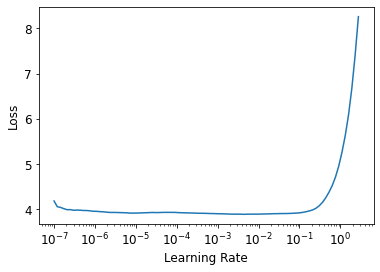

In [33]:
lr_min,lr_steep = learn.lr_find()

This Learning Rate versus Loss Curve looks quite similar to what we get for LMs trained on other domains of the project, such as Books. It does not have a nice minimum point, rather a large stretch before Loss rises quickly. 

In [34]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 4.37e-04, steepest point: 7.59e-07


In [35]:
learn.unfreeze()
learn.fit_one_cycle(1, 4e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.761826,3.796788,0.291498,44.557846,11:20


In [36]:
learn.save_encoder('finetuned_v5_19K')

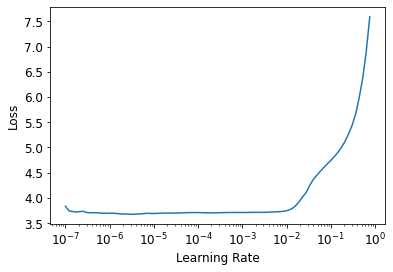

In [37]:
lr_min,lr_steep = learn.lr_find()

In [38]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 3.31e-07, steepest point: 1.32e-06


In [39]:
learn.unfreeze()
learn.fit_one_cycle(1, 3e-7)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.696072,3.797014,0.291490,44.567894,11:19


In [40]:
learn.unfreeze()
learn.fit_one_cycle(1, 3e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.682939,3.755613,0.296705,42.760418,11:36


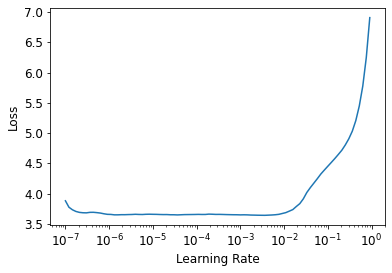

In [41]:
lr_min,lr_steep = learn.lr_find()

In [42]:
learn.unfreeze()
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.665859,3.674479,0.305424,39.428120,11:21


In [43]:
learn.save_encoder('finetuned_v5_19K_B')

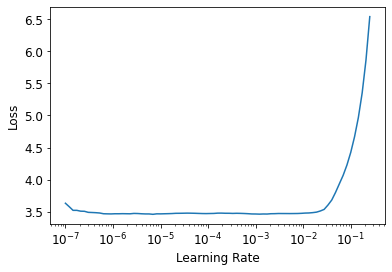

In [44]:
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [45]:
learn.unfreeze()
learn.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.499403,3.635622,0.310216,37.925426,11:26


In [46]:
learn.save_encoder('finetuned_v5_19K_C')

Let's stick with that LM and save it. 

### Training the Classifier


In [22]:
dls_cl = TextDataLoaders.from_df(
    train_unbal_df, 
    seed=42, 
    seq_len=72,
    text_col="reviewText", 
    label_col="is_helpful",
    valid_pct = 0.20, 
    bs = 64, 
    is_lm = False
)


/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [55]:
len(dls_cl.vocab[0])

35224

# Create the pre-trained text classifier
classifier = text_classifier_learner(dls_cl, AWD_LSTM, drop_mult=0.5, metrics=accuracy, loss_func=CrossEntropyLossFlat()).to_fp16()

# Use the encoder created above from the language model
classifier = classifier.load_encoder('2e2_2ep_2e3_2e4_19K')

In [23]:
classifier = text_classifier_learner(dls_cl, 
                                     AWD_LSTM, 
                                     drop_mult = 0.5, 
                                     metrics = accuracy).to_fp16()


In [24]:
classifier = classifier.load_encoder('finetuned_v5_19K_C')

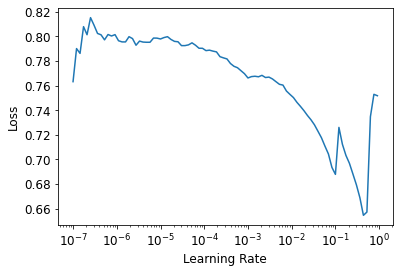

In [25]:
lr_min,lr_steep = classifier.lr_find()

In [26]:
classifier.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.291338,0.254115,0.908462,01:33


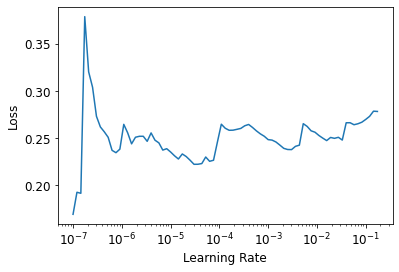

In [27]:
lr_min,lr_steep = classifier.lr_find()

In [28]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-5/(2.6**4),1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.234548,0.254626,0.907474,01:47


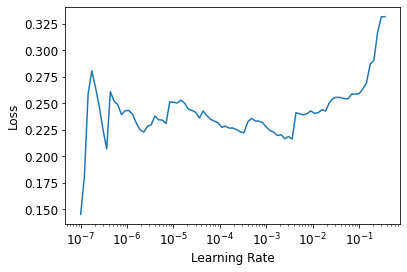

In [29]:
lr_min,lr_steep = classifier.lr_find()

In [30]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.269732,0.245760,0.912743,02:40


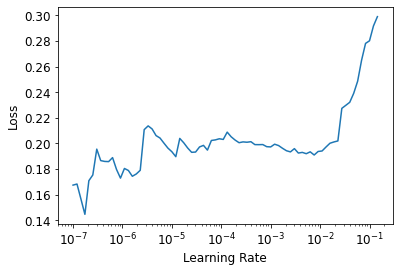

In [31]:
lr_min,lr_steep = classifier.lr_find()

In [32]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.201687,0.245491,0.915706,03:24


In [33]:
classifier.save("classifier_15K_forward")

Path('models/classifier_15K_forward.pth')

Since around 85% of our training data belong to the category "helpful" and only 15% to "not helpful", we might have to take our accuracy of 91% with a grain of salt. 